In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
import networkx as nx
import community as community_louvain
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import balanced_accuracy_score, silhouette_score, confusion_matrix

from sklearn.metrics.cluster import normalized_mutual_info_score, \
                                    adjusted_mutual_info_score, \
                                    v_measure_score, \
                                    adjusted_rand_score

from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.manifold import TSNE

from sklearn_som.som import SOM

In [2]:
def cluster_acc(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    _make_cost_m = lambda x:-x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:,np.newaxis],indexes[1][:,np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc

In [3]:
def read_data(name, data_sep=' ', has_labels=True):
    data_path =  f'/media/marcos/DATA/datasets/preprocessed/{name}.csv'

    data = pd.read_csv(data_path, data_sep)
#     data = data.sample(frac = 1)
    
    X = data
    y = []
    if has_labels:
        y = data['Y']
        X = data.drop(['Y'], axis=1)
        print(len(np.unique(y)))
        
    print(X.shape)
    
    return X, y

In [4]:
def get_clustering(S, X):
    G = nx.from_numpy_array(S)
    partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)

    clustering = []
    for key, value in partition.items():
        clustering.append(value)

    print('n_clusters: ', len(np.unique(clustering)))
    
    avg_sil = silhouette_score(X, clustering, metric='euclidean')
    
    print('sil: ', avg_sil)
    
    return clustering

In [5]:
def encoder_data(X, X_train, X_test, encoder_size=100):
    n_inputs = X.shape[1]
    # define encoder
    visible = Input(shape=(n_inputs,))
    # encoder level 1
    e = Dense(int(n_inputs/10))(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # encoder level 2
    e = Dense(int(n_inputs/20))(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # bottleneck
    n_bottleneck = encoder_size
    bottleneck = Dense(n_bottleneck)(e)
#     # define decoder, level 1
#     d = Dense(int(n_inputs/10))(bottleneck)
#     d = BatchNormalization()(d)
#     d = LeakyReLU()(d)
#     # decoder level 2
#     d = Dense(int(n_inputs/20))(d)
#     d = BatchNormalization()(d)
#     d = LeakyReLU()(d)
    
#     # output layer
#     output = Dense(n_inputs, activation='linear')(d)
#     # define autoencoder model
#     model = Model(inputs=visible, outputs=output)
#     # compile autoencoder model
#     model.compile(optimizer='adam', loss='mse')
    
#     history = model.fit(
#         X_train, X_train, 
#         epochs=20, 
#         batch_size=16, 
#         verbose=2, 
#         validation_data=(X_test,X_test)
#     )
    
    model = Model(inputs=visible, outputs=bottleneck)
    
#     model.compile(optimizer='adam', loss='mse')
    
#     history = model.fit(
#         X_train, X_train, 
#         epochs=20, 
#         batch_size=16, 
#         verbose=2, 
#         validation_data=(X_test,X_test)
#     )
    
    X_encoded = model.predict(X)
    
    return X_encoded

In [17]:
X, y = read_data('SMK_CAN', data_sep=' ')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

X_encoded = encoder_data(X, X_train, X_test, encoder_size=10)

/tmp/ipykernel_8355/470971451.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  X, y = read_data('SMK_CAN', data_sep=' ')


2
(187, 19993)


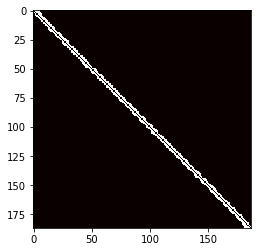

n_clusters:  12
sil:  0.42475563
acc:  0.24064171122994651
cr:  0.16693556830201056
v_meas:  0.4288782145234782
nmi:  0.41753552740148514


In [18]:
X_encoded_sorted = np.sort(X_encoded, axis=0)

# pd.DataFrame(X_encoded_sorted)
S = kneighbors_graph(X_encoded_sorted, n_neighbors=5)
plt.imshow(S.toarray(), cmap='hot', interpolation='nearest')
plt.show()

clustering = get_clustering(S, X_encoded_sorted)
acc = cluster_acc(y, clustering)
cr = adjusted_rand_score(y, clustering)
v_meas = v_measure_score(y, clustering)
nmi = adjusted_mutual_info_score(y, clustering)

print('acc: ', acc)
print('cr: ', cr)
print('v_meas: ', v_meas)
print('nmi: ', nmi)

In [19]:
A = kneighbors_graph(X_encoded_sorted, n_neighbors=5).toarray()
D = np.diag(A.sum(axis=0))

# print(D)

L = D - A
vals, vecs = np.linalg.eig(L)

# sort
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

S = kneighbors_graph(vecs[:,0:4].real, n_neighbors=5)
# use Fiedler value to find best cut to separate data
# clusters = vecs[:,1] > 0
# clusters

clustering = get_clustering(S, vecs[:,0:4].real)
acc = cluster_acc(y, clustering)
cr = adjusted_rand_score(y, clustering)
v_meas = v_measure_score(y, clustering)
nmi = adjusted_mutual_info_score(y, clustering)

print('acc: ', acc)
print('cr: ', cr)
print('v_meas: ', v_meas)
print('nmi: ', nmi)

n_clusters:  13
sil:  0.19923433871019083
acc:  0.20320855614973263
cr:  0.14403724900294274
v_meas:  0.3993314980516346
nmi:  0.3865680875524262


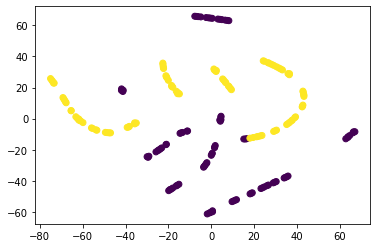

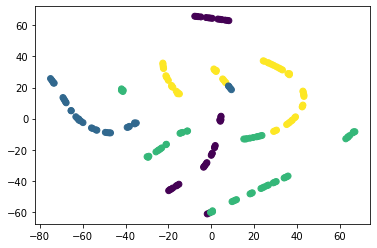

In [8]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_encoded_sorted)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)
plt.show()

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clustering)